# Introduction



### This kernel is mainly made up of two parts:
* [**1. Data loading**](#Data loading)
* [**2. Model building**](#Model building)

* Data are generated from this script : https://www.kaggle.com/qnkhuat/make-data-ready 
* Stacking part is from this script: https://www.kaggle.com/ashishpatel26/updated-bayesian-lgbm-xgb-cat-fe-kfold-cv

## Data loading

In [1]:
import numpy as np 
import pandas as pd 
import scipy
from datetime import datetime

import sys
import os
from os.path import join as pjoin

data_root = '../input/user-level-training-and-test-data-prepare'
print(os.listdir(data_root))

pd.set_option('display.max_rows',200)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

['train_clean7', 'train_clean5', 'train_clean2', 'train_clean0', 'custom.css', '__results__.html', 'train_clean6', 'train_clean3', 'test_clean', '__output__.json', '__notebook__.ipynb', 'train_clean1', 'train_clean4', 'train_clean8']


In [2]:
def load_data(data='train',n=2):
    df = pd.DataFrame()
    for i in range(n) :
        if data=='train':
            if i > 8 :
                break
            dfpart = pd.read_pickle(pjoin(data_root,f'train_clean{i}'))
        elif data=='test':
            if i > 2 :
                break
            dfpart = pd.read_pickle(pjoin(data_root,f'test_{i}.pkl'))
        df = pd.concat([df,dfpart])
        del dfpart
    return df       

In [3]:
df_train = load_data(n=9)
df_test = pd.read_pickle(pjoin(data_root,f'test_clean'))

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [4]:
df_train.shape, df_test.shape

((3134406, 61), (296530, 59))

In [5]:
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      df_train:  1.9 GiB
                       df_test: 176.1 MiB
                  LabelEncoder:  1.0 KiB
               StratifiedKFold:  1.0 KiB
                           _i5:  576.0 B
                           _i1:  556.0 B
                          _iii:  490.0 B
                           _i2:  490.0 B
                      datetime:  400.0 B
                           _oh:  240.0 B


## Model building

In [6]:
import lightgbm as lgb
# from xgboost import XGBRegressor
# from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error

In [7]:
df_train['month'] = df_train['month'].astype('category')
df_train['year'] = df_train['year'].astype('category')

In [8]:
df_test['month'] = df_test['month'].astype('category')
df_test['year'] = df_test['year'].astype('category')

In [9]:
# print(df_train.columns)
# col = 'adwordsClickInfo_page'
# print(len(df_train[col].unique()))
# print(df_train[col].mode())
# print(df_train[col].describe)

In [10]:
to_category = ['channelGrouping', 'device_browser', 'deviceCategory', 'operatingSystem',
              'networkDomain', 'city', 'metro', 'region', 'country', 'continent', 
              'adwordsClickInfo_gclId', 'keyword', 'medium', 'referralPath', 
              'source', 'adwordsClickInfo_page', 'totals_sessionQualityDim'] 

for col in to_category:
    df_train[col] = df_train[col].astype('category')
    df_test[col] = df_test[col].astype('category')

In [11]:
params_lgb2 = {
        "objective" : "binary",
        "metric" : "binary_logloss",
        "max_leaves": 256,
        "num_leaves" : 15,
        "min_child_samples" : 1,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.9,
        "feature_fraction" : 0.8,
        "bagging_frequency" : 1           
    }

In [12]:
params_lgb3 = {
        "objective" : "regression",
        "metric" : "rmse", 
        "max_leaves": 256,
        "num_leaves" : 9,
        "min_child_samples" : 1,
        "learning_rate" : 0.01,
        "bagging_fraction" : 0.9,
        "feature_fraction" : 0.8,
        "bagging_frequency" : 1      
    }

In [13]:
print(sum(df_train['ret'] ==1) / len(df_train), sum(df_train['ret'] ==1))

0.005969233085949937 18710


## Cross Validation

In [14]:
target_cols = ['totals_transactionRevenue', 'ret', 'fullVisitorId']

features = [c for c in df_train.columns if c not in target_cols]

In [15]:
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)

oof_pro = np.zeros(len(df_train))
oof_revenue = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))

feature_importance_pro = pd.DataFrame()
feature_importance_revenue = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train.values, df_train['ret'].values)):
    print("Fold {}".format(fold_))
    
    print("--------------train classification model----------------")
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][features], label=df_train.iloc[trn_idx]['ret'])
    val_data = lgb.Dataset(df_train.iloc[val_idx][features], label=df_train.iloc[val_idx]['ret'])
    
    num_round = 10000
    clf = lgb.train(params_lgb2, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds = 400)
    oof_pro[val_idx] = clf.predict(df_train.iloc[val_idx][features], num_iteration=clf.best_iteration) 
    pr_lgb = clf.predict(df_test[features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_pro = pd.concat([feature_importance_pro, fold_importance_df], axis=0)    
    
    print("--------------train regression model----------------")
    trn_fold = df_train.iloc[trn_idx]
    trn_ret = trn_fold[trn_fold['ret']==1]
    trn_data = lgb.Dataset(trn_ret[features], label = np.log1p(trn_ret['totals_transactionRevenue']))
    
    val_fold = df_train.iloc[val_idx]
    val_ret = val_fold[val_fold['ret']==1]
    val_data = lgb.Dataset(val_ret[features], label = np.log1p(val_ret['totals_transactionRevenue']))
    
    num_round = 10000
    reg = lgb.train(params_lgb3, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 1000)
    oof_revenue[val_idx] = reg.predict(df_train.iloc[val_idx][features], num_iteration=reg.best_iteration) * oof_pro[val_idx]  
    pr_lgb_ret = reg.predict(df_test[features], num_iteration = reg.best_iteration)
    
    predictions += pr_lgb * pr_lgb_ret / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = reg.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_revenue = pd.concat([feature_importance_revenue, fold_importance_df], axis=0) 
    

Fold 0
--------------train classification model----------------


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 400 rounds.
[200]	training's binary_logloss: 0.0279981	valid_1's binary_logloss: 0.0282736
[400]	training's binary_logloss: 0.0270587	valid_1's binary_logloss: 0.0275713
[600]	training's binary_logloss: 0.0265808	valid_1's binary_logloss: 0.0274076
[800]	training's binary_logloss: 0.0262416	valid_1's binary_logloss: 0.0273422
[1000]	training's binary_logloss: 0.0259598	valid_1's binary_logloss: 0.0273353
[1200]	training's binary_logloss: 0.0257079	valid_1's binary_logloss: 0.0273326
[1400]	training's binary_logloss: 0.0254894	valid_1's binary_logloss: 0.0273217
[1600]	training's binary_logloss: 0.0252936	valid_1's binary_logloss: 0.0273198
[1800]	training's binary_logloss: 0.0250739	valid_1's binary_logloss: 0.0273078
[2000]	training's binary_logloss: 0.0248843	valid_1's binary_logloss: 0.0273062
[2200]	training's binary_logloss: 0.0246992	valid_1's binary_logloss: 0.0272972
[2400]	training's binary_logloss: 0.0245446	valid_1's binary_

In [16]:
print("CV score of revenue: {:<8.5}".format(mean_squared_error(np.log1p(df_train['totals_transactionRevenue'].fillna(0)), oof_revenue)))
print("CV score of classification: {:<8.5f}".format(mean_squared_error(df_train['ret'], oof_pro)))      

CV score of revenue: 0.096909
CV score of classification: 0.00562 


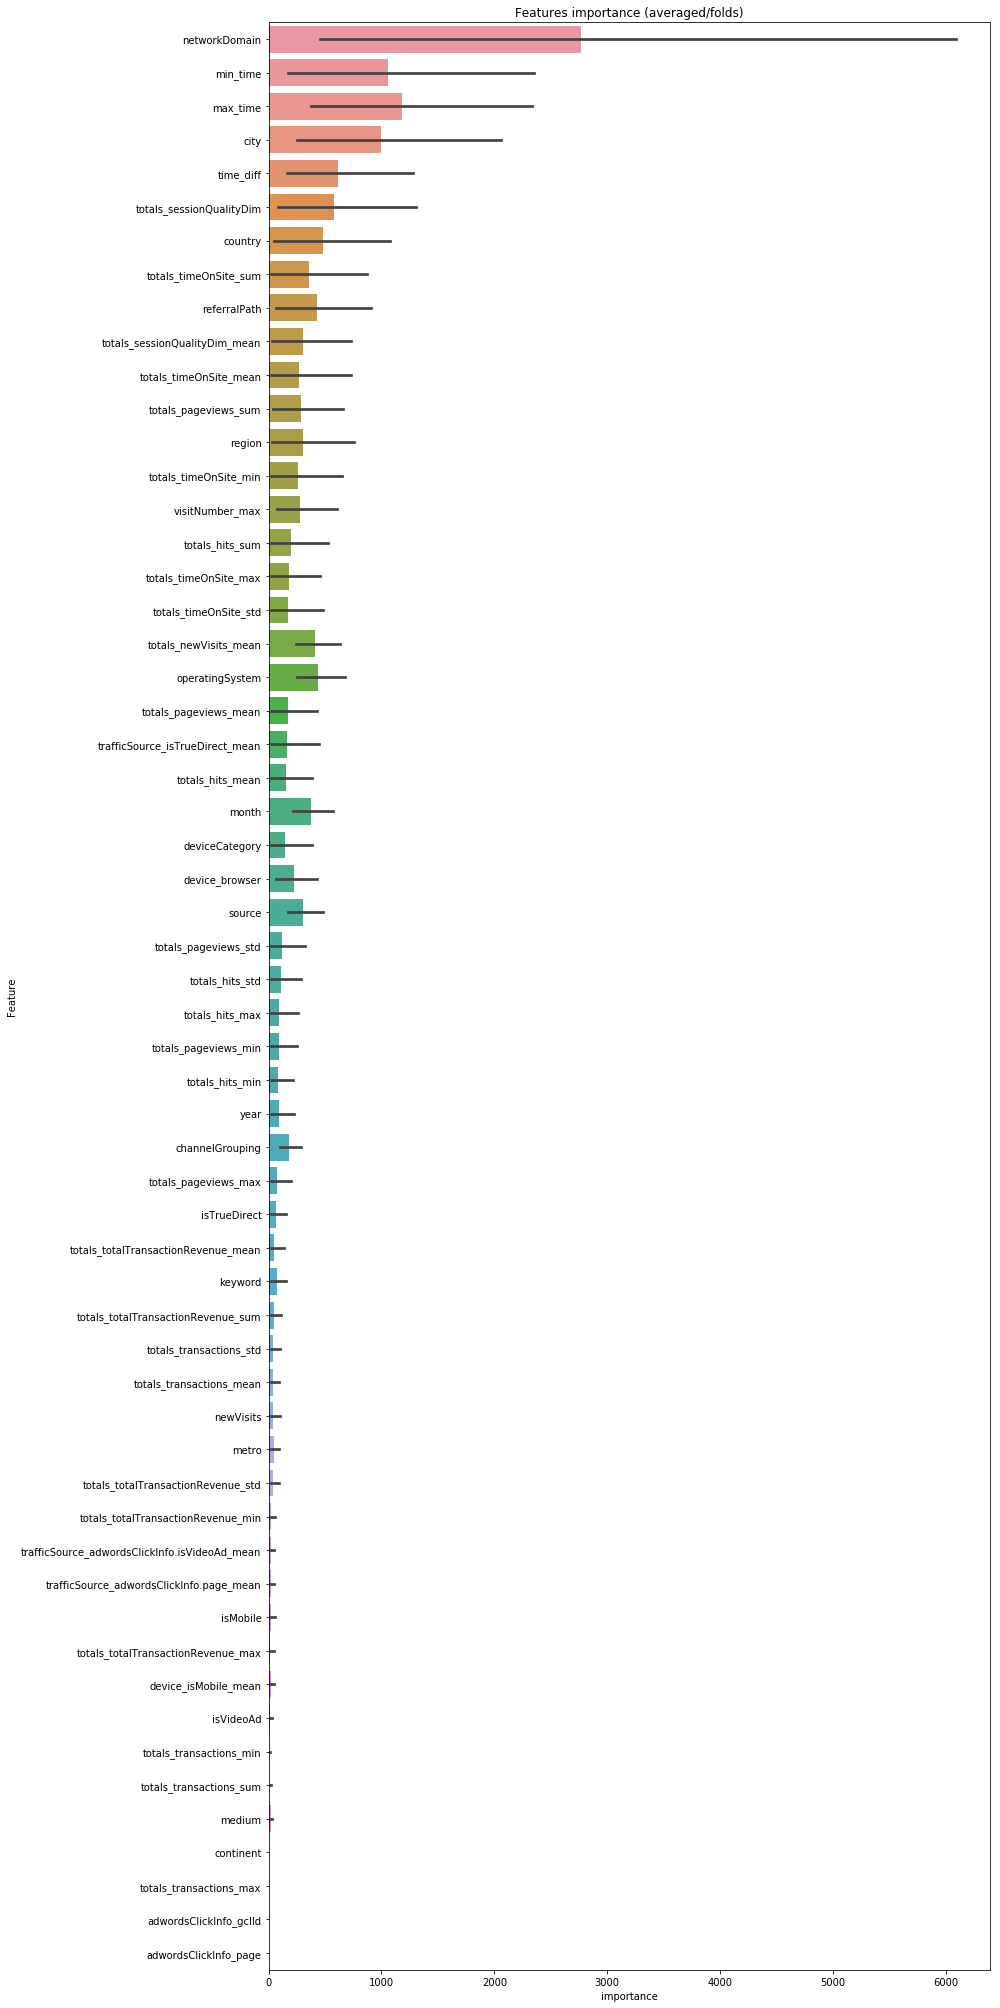

In [17]:
cols = (feature_importance_pro[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_pro.loc[feature_importance_pro.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

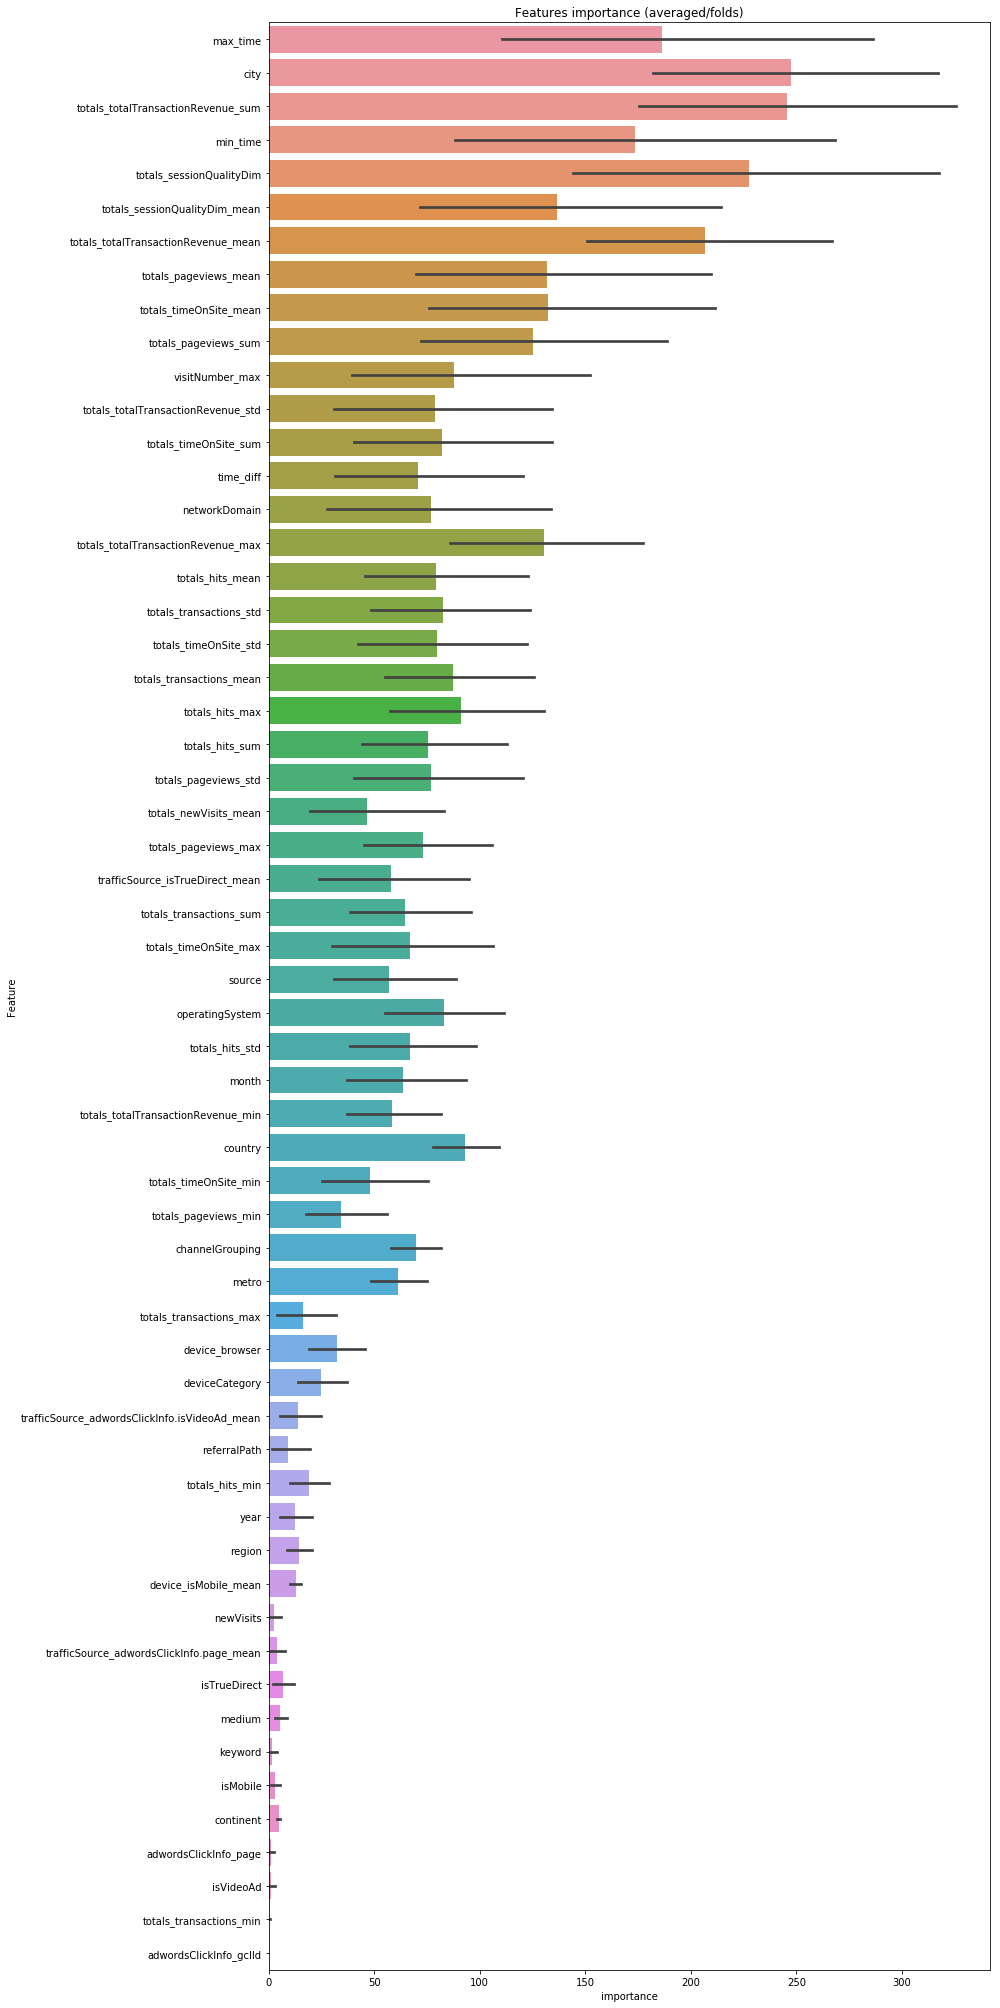

In [18]:
cols = (feature_importance_revenue[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_revenue.loc[feature_importance_revenue.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')

In [19]:
# pr_lgb_sum = 0

# num_ite = 1
# print('Training and predictions')
# for i in range(num_ite):
#     print('Interation number ', i)
#     lgb_model1 = lgb.train(params_lgb2, dtrain_all, num_boost_round=1250) # original 1200
#     pr_lgb = lgb_model1.predict(test)
    
#     lgb_model2 = lgb.train(params_lgb3, dtrain_ret, num_boost_round=390) # original 368
#     pr_lgb_ret = lgb_model2.predict(test)
    
#     pr_lgb_sum = pr_lgb_sum + pr_lgb*pr_lgb_ret

# pr_final2 = pr_lgb_sum/num_ite

## Save result

In [20]:
sub_df = pd.DataFrame(df_test['fullVisitorId'])
sub_df["PredictedLogRevenue"] = predictions
sub_df.head()

,fullVisitorId,PredictedLogRevenue
0,0000018966949534117,0.002881
1,0000039738481224681,0.000599
2,0000073585230191399,0.000634
3,0000087588448856385,0.000186
4,0000149787903119437,0.000167


In [21]:
sub_df.to_csv("stacked_result.csv", index=False)